<!-- Apenas treina, salva modelo/scaler e gera gráficos (sem MLflow) -->

In [ ]:
# ====================================
# 1. IMPORTS E CONFIGURAÇÕES
# ====================================

# Imports padrão
import sys
import warnings
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# Setup de caminhos
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

# Imports científicos
import numpy as np
import pandas as pd
import yaml
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from src.scripts.utils_train import inverse_transform_predictions,calculate_metrics, build_model

# ML/Deep Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import mlflow
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Customizados
from src.scripts.data_processor import StockDataProcessor


# Configuração global
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

print(f"✅ TensorFlow: {tf.__version__}")
print(f"✅ Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✅ Attention Mechanism: Habilitado")

✅ TensorFlow: 2.20.0
✅ Data: 2026-01-08 21:41:41
✅ Attention Mechanism: Habilitado


In [ ]:
# ====================================
# 2. DEFINIR HIPERPARÂMETROS DO MODELO
# ====================================

SYMBOL = 'AAPL'
START_DATE = '2018-01-01'
END_DATE = '2025-12-31'

# Configuração do Modelo - V1 BASELINE (retest após fix de target leakage)
model_config = {
    'sequence_length': 60,              # Voltando ao baseline
    'lstm_units': [100, 50],            # Baseline original
    'dropout_rate': 0.25,               # Baseline
    'recurrent_dropout': 0.0,           # Baseline (sem recurrent dropout)
    'dense_units': 16,                  # Baseline
    'learning_rate': 0.001,             # Baseline
    'batch_size': 32,                   # Baseline
    'epochs': 100,
    'regularization_l2': 0.003,         # Baseline
    'early_stop_patience': 15,
    'reduce_lr_patience': 8,
    'train_ratio': 0.7,
    'val_ratio': 0.2
}

print("=" * 80)
print("⚙️  V1 BASELINE - RETEST APÓS FIX DE TARGET LEAKAGE")
print("=" * 80)
print("\n🔧 CORREÇÕES APLICADAS:")
print("  ├─ Target: Agora prediz APENAS 'Close' (antes: todas as 6 features)")
print("  ├─ Features Input: Open, High, Low, Close, Volume, Adj Close")
print("  ├─ Scaler: MinMaxScaler (antes estava StandardScaler)")
print("  └─ Target Leakage: ELIMINADO!\n")
print("📊 Configuração:")
print(f"  ├─ Sequence Length: {model_config['sequence_length']} dias")
print(f"  ├─ LSTM Units: {model_config['lstm_units']}")
print(f"  ├─ Dropout: {model_config['dropout_rate']}")
print(f"  ├─ L2 Regularization: {model_config['regularization_l2']}")
print(f"  ├─ Batch Size: {model_config['batch_size']}")
print(f"  └─ Learning Rate: {model_config['learning_rate']}\n")
print("🎯 Expectativa: R² gap deve reduzir drasticamente (~20-40%)")
print("   (antes estava 80% devido ao target leakage)")


⚙️  V1 BASELINE - RETEST APÓS FIX DE TARGET LEAKAGE

🔧 CORREÇÕES APLICADAS:
  ├─ Target: Agora prediz APENAS 'Close' (antes: todas as 6 features)
  ├─ Features Input: Open, High, Low, Close, Volume, Adj Close
  ├─ Scaler: MinMaxScaler (antes estava StandardScaler)
  └─ Target Leakage: ELIMINADO!

📊 Configuração:
  ├─ Sequence Length: 60 dias
  ├─ LSTM Units: [100, 50]
  ├─ Dropout: 0.25
  ├─ L2 Regularization: 0.003
  ├─ Batch Size: 32
  └─ Learning Rate: 0.001

🎯 Expectativa: R² gap deve reduzir drasticamente (~20-40%)
   (antes estava 80% devido ao target leakage)


In [ ]:
# Recarregar módulo (importante depois de editar src/scripts/data_processor.py)
import importlib
import src.scripts.data_processor
importlib.reload(src.scripts.data_processor)
from src.scripts.data_processor import StockDataProcessor

print("\nProcessando dados para LSTM...")
processor = StockDataProcessor(SYMBOL, START_DATE, END_DATE)
processed_df, lstm_data = processor.process_pipeline(
    sequence_length=model_config['sequence_length'],
    train_ratio=model_config['train_ratio'],
    val_ratio=model_config['val_ratio']
)

2026-01-08 21:41:41,687 - src.scripts.data_processor - INFO - StockDataProcessor inicializado para AAPL
2026-01-08 21:41:41,687 - src.scripts.data_processor - INFO - Carregando dados para AAPL
2026-01-08 21:41:41,693 - src.scripts.cache_manager - INFO - Dados carregados do cache: AAPL
2026-01-08 21:41:41,695 - src.scripts.data_processor - INFO - Preparando LSTM com 6 features
2026-01-08 21:41:41,696 - src.scripts.data_processor - INFO - Features: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
2026-01-08 21:41:41,704 - src.scripts.data_processor - INFO - 
✅ Dataset split:
2026-01-08 21:41:41,704 - src.scripts.data_processor - INFO -   Treino: 1365 sequências (70.0%)
2026-01-08 21:41:41,705 - src.scripts.data_processor - INFO -   Validação: 390 sequências (20.0%)
2026-01-08 21:41:41,705 - src.scripts.data_processor - INFO -   Teste: 195 sequências (10.0%)
2026-01-08 21:41:41,706 - src.scripts.data_processor - INFO -   Shape X_train: (1365, 60, 6) (samples,


Processando dados para LSTM...


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_names = lstm_data

print(f"\n✅ Sequências Preparadas:")
print(f"   X_train: {X_train.shape}  (samples, timesteps, features)")
print(f"   y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")
print(f"\n   Features utilizadas: {len(feature_names)}")
print(f"   Primeiras 5 features: {feature_names[:5]}")


✅ Sequências Preparadas:
   X_train: (1365, 60, 6)  (samples, timesteps, features)
   y_train: (1365,)
   X_val:   (390, 60, 6)
   y_val:   (390,)
   X_test:  (195, 60, 6)
   y_test:  (195,)

   Features utilizadas: 6
   Primeiras 5 features: Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [ ]:
root_dir = project_root
local_model_dir = root_dir / 'models'
local_model_dir.mkdir(parents=True, exist_ok=True)

mlflow.set_experiment("LSTM_Stock_Prediction")
    
with mlflow.start_run():
    
    # Log dos parâmetros no início
    mlflow.log_params(model_config)
    mlflow.log_param("symbol", SYMBOL)
    mlflow.log_param("start_date", START_DATE)
    mlflow.log_param("end_date", END_DATE)
    
    # Tags descritivas
    mlflow.set_tags({
        "model_type": "LSTM",
        "target": "Close Price",
        "framework": "TensorFlow/Keras"
    })
    
    print("\n" + "=" * 80)
    print("TREINANDO MODELO")
    print("=" * 80)
    
    # Construção do modelo com input_shape CORRETO
    input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
    print(f"\n📐 Input shape: {input_shape}")
    model = build_model(model_config, input_shape)
    
    # Callbacks para melhor treinamento
    early_stop = EarlyStopping(monitor='val_loss', patience=model_config['early_stop_patience'], restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=model_config['reduce_lr_patience'], verbose=1)
    
    # Treinamento
    
    print(f"\n📊 INICIANDO TREINAMENTO")
    print(f"   Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"   Épocas: {model_config['epochs']}")
    print(f"   Batch size: {model_config['batch_size']}")
    print(f"   Learning rate: {model_config['learning_rate']}")  
    
      
    history = model.fit(
        X_train, y_train, 
        batch_size=model_config['batch_size'], 
        epochs=model_config['epochs'], 
        validation_data=(X_val, y_val),  
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    print(f"\n✅ Treinamento concluído!")
    print(f"   Épocas executadas: {len(history.history['loss'])}")
    print(f"   Loss final: {history.history['loss'][-1]:.6f}")
    print(f"   Val Loss final: {history.history['val_loss'][-1]:.6f}")
    
    # Detector simples de overfitting com base na curva de val_loss
    val_hist = history.history.get('val_loss', [])
    if len(val_hist) > 2:
        min_idx = int(np.argmin(val_hist))
        min_val = float(np.min(val_hist))
        last_val = float(val_hist[-1])
        overfit_flag = (last_val > min_val * 1.02) and ((len(val_hist) - 1) - min_idx >= 3)
        print(f"\n🔎 Diagnóstico val_loss:")
        print(f"   Época do menor val_loss: {min_idx+1} / {len(val_hist)}")
        print(f"   Menor val_loss: {min_val:.6f} | Último val_loss: {last_val:.6f}")
        print(f"   Overfitting detectado? {'SIM' if overfit_flag else 'NÃO'}")
        mlflow.set_tag("overfit_detected", str(overfit_flag))
        mlflow.log_metric("val_loss_min", min_val)
        mlflow.log_metric("val_loss_last", last_val)
        mlflow.log_metric("val_loss_min_epoch", min_idx+1)

    # 3. Avaliação e Métricas
    print("\n📊 Avaliando no conjunto de teste...")
    
    y_train_pred = model.predict(X_train, verbose=0).flatten()
    y_val_pred = model.predict(X_val, verbose=0).flatten()
    y_test_pred = model.predict(X_test, verbose=0).flatten()
    
    # Inverter normalização
    y_train_orig, y_train_pred_orig = inverse_transform_predictions(y_train, y_train_pred, scaler, feature_names)
    y_val_orig, y_val_pred_orig = inverse_transform_predictions(y_val, y_val_pred, scaler, feature_names)
    y_test_orig, y_test_pred_orig = inverse_transform_predictions(y_test, y_test_pred, scaler, feature_names)

    # Calcular métricas
    train_metrics = calculate_metrics(y_train_orig, y_train_pred_orig, 'Treino')
    val_metrics = calculate_metrics(y_val_orig, y_val_pred_orig, 'Validação')
    test_metrics = calculate_metrics(y_test_orig, y_test_pred_orig, 'Teste')

    # Exibir resultados
    results_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])
    print("\n" + "=" * 100)
    print("MÉTRICAS DE DESEMPENHO")
    print("=" * 100)
    print(results_df.round(4).to_string(index=False))

    print(f"\n✅ Modelo Treinado com Sucesso!")
    print(f"   R² Teste: {test_metrics['R² Score']:.4f} ({test_metrics['R² Score']*100:.2f}%)")
    print(f"   MAE Teste: ${test_metrics['MAE ($)']:.2f}")
    
    val_loss = min(history.history['val_loss'])
    mae = test_metrics['MAE ($)']
    rmse = test_metrics['RMSE ($)']
    mape = test_metrics['MAPE (%)']
    
    print(f"\n📈 Métricas de Teste:")
    print(f"  MAE: ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    
    # Log todas as métricas
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("val_loss", val_loss)
    mlflow.log_metric("final_epoch", len(history.history['loss']))

    # Salvar Modelo
    model_path = local_model_dir / 'lstm_model.keras'
    model.save(str(model_path))
    print(f"\n💾 Modelo salvo em: {model_path}")
        
    # Log do modelo no MLflow
    mlflow.keras.log_model(model, "model")
    
    # Salvar e logar scaler como artefato
    scaler_path = local_model_dir / 'scaler.pkl'
    joblib.dump(scaler, scaler_path)
    mlflow.log_artifact(str(scaler_path), artifact_path="preprocessing")
    
    # Gerar e logar gráficos
    temp_plots_dir = root_dir / 'data' / 'temp_plots'
    temp_plots_dir.mkdir(parents=True, exist_ok=True)
    
    # Gráfico de Validação
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig, color='blue', label='Real', linewidth=2)
    plt.plot(y_test_pred_orig, color='red', label='Previsto', linewidth=2)
    plt.title(f'Previsão vs Real - {SYMBOL}', fontsize=14)
    plt.xlabel('Tempo')
    plt.ylabel('Preço ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    temp_validation_path = temp_plots_dir / 'validation_plot.png'
    plt.savefig(str(temp_validation_path), dpi=100, bbox_inches='tight')
    mlflow.log_artifact(str(temp_validation_path), artifact_path="plots")
    plt.close()
    
    # Gráfico de Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Treino', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validação', linewidth=2)
    plt.title('Curva de Aprendizado', fontsize=14)
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    temp_loss_path = temp_plots_dir / 'loss_plot.png'
    plt.savefig(str(temp_loss_path), dpi=100, bbox_inches='tight')
    mlflow.log_artifact(str(temp_loss_path), artifact_path="plots")
    plt.close()
    
    # Resíduos (para diagnóstico de overfitting e heterocedasticidade)
    residuals_train = y_train_orig - y_train_pred_orig
    residuals_val = y_val_orig - y_val_pred_orig
    residuals_test = y_test_orig - y_test_pred_orig
    
    # Resíduos ao longo do tempo (teste)
    plt.figure(figsize=(12, 6))
    plt.plot(residuals_test, label='Resíduo (Teste)', color='purple', linewidth=1.5)
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.title('Resíduos ao Longo do Tempo - Teste', fontsize=14)
    plt.xlabel('Índice de tempo (teste)')
    plt.ylabel('Resíduo (Real - Previsto)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    temp_resid_time_path = temp_plots_dir / 'residuals_time_test.png'
    plt.savefig(str(temp_resid_time_path), dpi=100, bbox_inches='tight')
    mlflow.log_artifact(str(temp_resid_time_path), artifact_path="plots")
    plt.close()
    
    # Distribuição dos resíduos (treino vs validação vs teste)
    plt.figure(figsize=(12, 6))
    sns.kdeplot(residuals_train, label='Treino', fill=True, alpha=0.35)
    sns.kdeplot(residuals_val, label='Validação', fill=True, alpha=0.35)
    sns.kdeplot(residuals_test, label='Teste', fill=True, alpha=0.35)
    plt.title('Distribuição dos Resíduos', fontsize=14)
    plt.xlabel('Resíduo (Real - Previsto)')
    plt.ylabel('Densidade')
    plt.legend()
    plt.grid(True, alpha=0.3)
    temp_resid_dist_path = temp_plots_dir / 'residuals_distribution.png'
    plt.savefig(str(temp_resid_dist_path), dpi=100, bbox_inches='tight')
    mlflow.log_artifact(str(temp_resid_dist_path), artifact_path="plots")
    plt.close()
    
    # Dispersão: previsões vs resíduos (teste)
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_pred_orig, residuals_test, alpha=0.45, s=25, color='teal', edgecolor='white')
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.title('Previsão vs Resíduo - Teste', fontsize=14)
    plt.xlabel('Preço Previsto')
    plt.ylabel('Resíduo (Real - Previsto)')
    plt.grid(True, alpha=0.3)
    temp_resid_scatter_path = temp_plots_dir / 'residuals_scatter_test.png'
    plt.savefig(str(temp_resid_scatter_path), dpi=100, bbox_inches='tight')
    mlflow.log_artifact(str(temp_resid_scatter_path), artifact_path="plots")
    plt.close()
    
    print("✅ Treinamento e artefatos salvos no MLflow")
    print(f"   Plots salvos em: {temp_plots_dir}")


TREINANDO MODELO

📐 Input shape: (60, 6)

📊 INICIANDO TREINAMENTO
   Data: 2026-01-08 21:41:41
   Épocas: 100
   Batch size: 32
   Learning rate: 0.001
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0220 - mape: 16431.4805 - val_loss: 0.0132 - val_mape: 8.4983 - learning_rate: 0.0010
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0046 - mape: 19763.7500 - val_loss: 0.0083 - val_mape: 6.4361 - learning_rate: 0.0010
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0043 - mape: 1180.2568 - val_loss: 0.0060 - val_mape: 5.4556 - learning_rate: 0.0010
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041 - mape: 2114.5383 - val_loss: 0.0027 - val_mape: 3.8357 - learning_rate: 0.0010
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0037 - mape: 6669.2017 - val_loss: 0.0025 - val_mape: 3.7259 - learning_rate: 0.0010
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030 - mape: 14833.9336 - val_loss: 0.0022 - val

2026/01/08 21:42:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/08 21:42:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.



MÉTRICAS DE DESEMPENHO
  Dataset  MAE ($)  RMSE ($)  MAPE (%)  R² Score  Dir. Accuracy (%)
   Treino   2.9623    4.1050    2.8030    0.9928            51.3930
Validação   5.3000    6.6705    2.5274    0.9331            54.2416
    Teste   9.1502   11.2671    3.8446    0.8519            47.9381

✅ Modelo Treinado com Sucesso!
   R² Teste: 0.8519 (85.19%)
   MAE Teste: $9.15

📈 Métricas de Teste:
  MAE: $9.15
  RMSE: $11.27
  MAPE: 3.84%

💾 Modelo salvo em: /home/isapt/docs/lstm-predict/models/lstm_model.keras
✅ Treinamento e artefatos salvos no MLflow
   Plots salvos em: /home/isapt/docs/lstm-predict/data/temp_plots


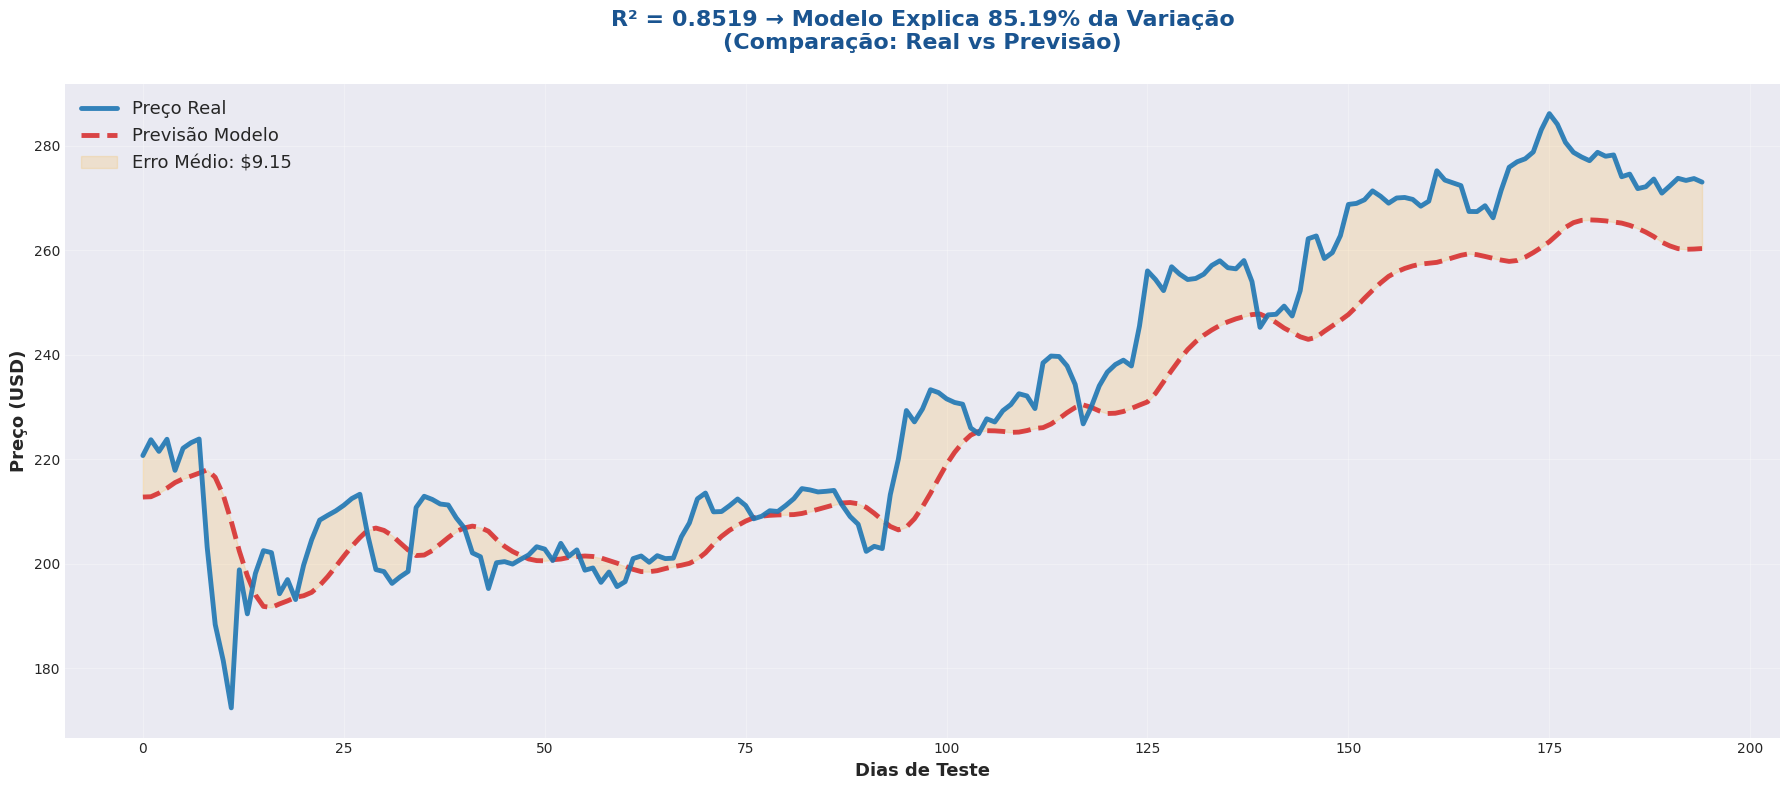


✅ Gráfico gerado com sucesso!


In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

days = range(len(y_test_orig))

ax.plot(days, y_test_orig, label='Preço Real', linewidth=3.5, color='#1f77b4', alpha=0.9, zorder=3)
ax.plot(days, y_test_pred_orig, label='Previsão Modelo', linewidth=3.5, color='#d62728', 
        linestyle='--', alpha=0.85, zorder=2)

mean_error = np.mean(np.abs(y_test_orig - y_test_pred_orig))

ax.fill_between(days, y_test_orig, y_test_pred_orig, alpha=0.15, color='orange', 
                label=f'Erro Médio: ${mean_error:.2f}')

ax.set_title(f'R² = {test_metrics["R² Score"]:.4f} → Modelo Explica {test_metrics["R² Score"]*100:.2f}% da Variação\n(Comparação: Real vs Previsão)', 
             fontsize=16, fontweight='bold', pad=25, color='#1a5490')
ax.set_ylabel('Preço (USD)', fontsize=13, fontweight='bold')
ax.set_xlabel('Dias de Teste', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=13, framealpha=0.95, edgecolor='black', fancybox=True)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.7)

plt.tight_layout()
plt.show()

print(f"\n✅ Gráfico gerado com sucesso!")

In [ ]:
print("\n📊 RESUMO DA ARQUITETURA:")
model.summary()


📊 RESUMO DA ARQUITETURA:


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 60, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,501 (865.24 KB)

 Trainable params: 73,833 (288.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 147,668 (576.83 KB)